In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 256
use_gpu = True
y_scale = True
lr = 0.001
weight_decay = 10

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

## Imputer, Scaler, Feature selection

In [6]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [7]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)

X_test = X_test.drop(columns=['building_id'], axis=1)

### X sacle

In [8]:
print(X.shape)
X = pipeline.fit_transform(X)

print(X_test.shape)
X_test = pipeline.fit_transform(X_test)
X_test = scale(X_test)


(60000, 233)
(10000, 233)


### y scale 

In [9]:
y_scaler = StandardScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
else:
    y = y.values
y

array([[-0.22254145],
       [-0.17412337],
       [-0.06095855],
       ...,
       [-0.02031481],
       [ 0.09321507],
       [-0.08016372]])

In [10]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [11]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [12]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 233])
torch.Size([10000, 233])
torch.Size([42000, 1])


In [13]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [14]:
class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        
        self.bn = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = self.fc1(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = self.dropout(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        return x

In [15]:
model = DNN().to(device)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [33]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = criterion(pred, batch_y)
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return model,  np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = criterion(pred, batch_y)
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return eval_loss

def test_func(model, X, y):
    model.eval()
    
    with torch.no_grad():
        pred = model(X)
        pred = pred.cpu().numpy()
        
        if y_scale:
            pred = denormalize(pred, y)
            print(pred)
    return pred

def denormalize(pred, y):
    scaler = StandardScaler()
    a = scaler.fit_transform(y)
    new = y_scaler.inverse_transform(pred)
    return new

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [17]:
train_losses = []
eval_losses = []
for t in range(5000):
    print('epochs', t)
    model, train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        eval_losses.append(eval_loss)
    
        train_losses.append(train_loss)
    

epochs 0
training loss 0.9453793211868315
epochs 1
training loss 0.9189067497397914
epochs 2
training loss 0.9182329262296359
epochs 3
training loss 0.9156054282278726
epochs 4
training loss 0.8987205087461255
epochs 5
training loss 0.9028282335761821
epochs 6
training loss 0.8633963395022984
epochs 7
training loss 0.9065114172119083
epochs 8
training loss 0.8761432760592663
epochs 9
training loss 0.8712122242559086
testing loss 0.06363709270954132
epochs 10
training loss 0.8570462688352123
epochs 11
training loss 0.8681551934304562
epochs 12
training loss 0.8566376897478194
epochs 13
training loss 0.862454287504608
epochs 14
training loss 0.8565286141227592
epochs 15
training loss 0.864148928992676
epochs 16
training loss 0.8800546829899152
epochs 17
training loss 0.8637195601043376
epochs 18
training loss 0.8947783917414419
epochs 19
training loss 0.9229802515244845
testing loss 0.08566135913133621
epochs 20
training loss 0.90705753433885
epochs 21
training loss 0.8614044337787411
ep

training loss 0.8093348317977154
epochs 178
training loss 0.6208131611460086
epochs 179
training loss 0.4938111898122412
testing loss 0.10547979921102524
epochs 180
training loss 0.7612131037100246
epochs 181
training loss 0.5172157143101548
epochs 182
training loss 0.5290350662036376
epochs 183
training loss 0.720533143006491
epochs 184
training loss 0.7039735790680756
epochs 185
training loss 0.5765305746008049
epochs 186
training loss 0.5230439454768643
epochs 187
training loss 0.4336618982707009
epochs 188
training loss 0.5683122724746212
epochs 189
training loss 0.5446544607028817
testing loss 0.07289701700210571
epochs 190
training loss 0.7736561349621325
epochs 191
training loss 0.554228619745735
epochs 192
training loss 0.7291415397642237
epochs 193
training loss 0.5382962339190822
epochs 194
training loss 0.4685030150819908
epochs 195
training loss 0.4912826153816599
epochs 196
training loss 1.5060671237382022
epochs 197
training loss 0.7936394220726056
epochs 198
training los

training loss 0.43447600092851757
epochs 352
training loss 0.7514831069405332
epochs 353
training loss 0.6354364460390626
epochs 354
training loss 0.55266526444166
epochs 355
training loss 0.6031330108191028
epochs 356
training loss 0.38058755856120224
epochs 357
training loss 0.47552071492554565
epochs 358
training loss 0.6724901901727373
epochs 359
training loss 0.570156342581366
testing loss 0.08241667598485947
epochs 360
training loss 0.5933369728651914
epochs 361
training loss 0.717860037980206
epochs 362
training loss 0.4885159101450082
epochs 363
training loss 0.4172984842549671
epochs 364
training loss 0.6680382844625097
epochs 365
training loss 0.5696303049045982
epochs 366
training loss 0.4272558221085505
epochs 367
training loss 0.6707327514773969
epochs 368
training loss 0.6886850286839586
epochs 369
training loss 0.47816909251339507
testing loss 0.18162038922309875
epochs 370
training loss 0.5721517337091041
epochs 371
training loss 0.6272319010487108
epochs 372
training l

training loss 0.6420259849817463
epochs 526
training loss 0.5830745922570879
epochs 527
training loss 0.6001564537711216
epochs 528
training loss 0.6197561906142668
epochs 529
training loss 0.4219533841944102
testing loss 0.02666095271706581
epochs 530
training loss 0.530016675772089
epochs 531
training loss 0.47476481955611344
epochs 532
training loss 0.4754048573248314
epochs 533
training loss 0.6941277660881028
epochs 534
training loss 0.5270912504783183
epochs 535
training loss 0.5529517536813563
epochs 536
training loss 0.473180749673735
epochs 537
training loss 0.5103006878133977
epochs 538
training loss 0.4156865762490215
epochs 539
training loss 0.7507040720771659
testing loss 0.26905855536460876
epochs 540
training loss 0.5553868603074189
epochs 541
training loss 0.42013113647699357
epochs 542
training loss 0.5497492410919883
epochs 543
training loss 0.7591211497783661
epochs 544
training loss 0.686720693427505
epochs 545
training loss 0.6509974591038895
epochs 546
training lo

training loss 0.5765141840008172
testing loss 0.04085220769047737
epochs 700
training loss 0.4317539943664363
epochs 701
training loss 0.38265063652034964
epochs 702
training loss 0.5115246193991466
epochs 703
training loss 0.4391639868644151
epochs 704
training loss 0.3899813156405633
epochs 705
training loss 0.5361765223470601
epochs 706
training loss 0.5131834091336438
epochs 707
training loss 0.3771790647145474
epochs 708
training loss 0.3546670869670131
epochs 709
training loss 0.4884298801422119
testing loss 0.6984444856643677
epochs 710
training loss 0.4778604580597444
epochs 711
training loss 0.4103149199350314
epochs 712
training loss 0.47693807753649625
epochs 713
training loss 0.36169820427894595
epochs 714
training loss 0.4216815014115789
epochs 715
training loss 0.5860955731209481
epochs 716
training loss 0.4626844382082874
epochs 717
training loss 0.5287095637371143
epochs 718
training loss 0.4500351859764619
epochs 719
training loss 0.33558119334506264
testing loss 0.467

training loss 0.4984098044082974
epochs 872
training loss 0.4518107566192295
epochs 873
training loss 0.39359088071593734
epochs 874
training loss 0.496589818032402
epochs 875
training loss 0.3877568887998209
epochs 876
training loss 1.0814623401697838
epochs 877
training loss 0.4411283772100102
epochs 878
training loss 0.4023616181855852
epochs 879
training loss 0.46302916048602627
testing loss 0.043733712285757065
epochs 880
training loss 0.5059120441024954
epochs 881
training loss 0.28707802907535523
epochs 882
training loss 0.3658531333009402
epochs 883
training loss 0.640938709382758
epochs 884
training loss 0.4409122502036167
epochs 885
training loss 0.4815204944122921
epochs 886
training loss 0.4669479010005792
epochs 887
training loss 0.3989826959642497
epochs 888
training loss 0.3025039471008561
epochs 889
training loss 0.2993499445870067
testing loss 0.1934400498867035
epochs 890
training loss 0.32099525607896573
epochs 891
training loss 0.44868944198118915
epochs 892
trainin

training loss 0.49220545711278013
epochs 1044
training loss 0.44353311228932757
epochs 1045
training loss 0.3681879757705963
epochs 1046
training loss 0.46058056250101687
epochs 1047
training loss 0.4525944170852502
epochs 1048
training loss 0.34375798600641166
epochs 1049
training loss 0.6454512383901712
testing loss 0.06543570011854172
epochs 1050
training loss 0.36571298214522274
epochs 1051
training loss 0.41295225987154427
epochs 1052
training loss 0.6888597805165884
epochs 1053
training loss 0.3568772985628157
epochs 1054
training loss 0.7160852555524219
epochs 1055
training loss 0.6015875508613658
epochs 1056
training loss 0.45264282937754285
epochs 1057
training loss 0.4123742118477821
epochs 1058
training loss 0.38380039666186677
epochs 1059
training loss 0.4613177970898422
testing loss 0.43942227959632874
epochs 1060
training loss 0.39313392867193075
epochs 1061
training loss 0.36990577481461295
epochs 1062
training loss 0.5482046155089682
epochs 1063
training loss 0.60669155

training loss 0.34788937193877767
epochs 1213
training loss 0.5514831026395162
epochs 1214
training loss 0.5813804021161614
epochs 1215
training loss 0.43098563991035477
epochs 1216
training loss 0.36726811794620573
epochs 1217
training loss 0.4627098788479061
epochs 1218
training loss 0.513114707916975
epochs 1219
training loss 0.5817419770089063
testing loss 0.04808441177010536
epochs 1220
training loss 0.40499890078649375
epochs 1221
training loss 0.5260541888461872
epochs 1222
training loss 0.4884324177196532
epochs 1223
training loss 0.33072081262415104
epochs 1224
training loss 0.2821673107982585
epochs 1225
training loss 0.3514119463210756
epochs 1226
training loss 0.35808420698299553
epochs 1227
training loss 0.4682218217714266
epochs 1228
training loss 0.4936539938729821
epochs 1229
training loss 0.33004548931212135
testing loss 0.09635472297668457
epochs 1230
training loss 0.4332622622450193
epochs 1231
training loss 0.3843104379195156
epochs 1232
training loss 0.380443497205

training loss 0.5022426626447475
epochs 1382
training loss 0.525459326397289
epochs 1383
training loss 0.3629196305843917
epochs 1384
training loss 0.32274702261343147
epochs 1385
training loss 0.5061575239354914
epochs 1386
training loss 0.36373177351373615
epochs 1387
training loss 0.393562084933122
epochs 1388
training loss 0.4943568530069156
epochs 1389
training loss 0.3571785489492344
testing loss 0.06309650093317032
epochs 1390
training loss 0.3742883523305257
epochs 1391
training loss 0.33546615578798633
epochs 1392
training loss 0.6968630561774427
epochs 1393
training loss 0.5918922644447197
epochs 1394
training loss 0.5055132682914987
epochs 1395
training loss 0.35008972201383476
epochs 1396
training loss 0.467219867941105
epochs 1397
training loss 0.6766234953633764
epochs 1398
training loss 0.466649409496423
epochs 1399
training loss 0.35731058371337976
testing loss 0.024488553404808044
epochs 1400
training loss 0.4829304115338759
epochs 1401
training loss 0.3964280320613673

training loss 0.3274385997291767
epochs 1551
training loss 0.5364971995353699
epochs 1552
training loss 0.2880823584217014
epochs 1553
training loss 0.3641251076125737
epochs 1554
training loss 0.5884045824408531
epochs 1555
training loss 0.4172367123604724
epochs 1556
training loss 0.2593274615253463
epochs 1557
training loss 0.2932816090005817
epochs 1558
training loss 0.42414120117371734
epochs 1559
training loss 0.5607588855380362
testing loss 0.3315888047218323
epochs 1560
training loss 0.5530911259804712
epochs 1561
training loss 0.3902163569222797
epochs 1562
training loss 0.2883297262995532
epochs 1563
training loss 0.2808914923758218
epochs 1564
training loss 0.390718331865289
epochs 1565
training loss 0.3766719639075525
epochs 1566
training loss 0.3548995101542184
epochs 1567
training loss 0.5702552443539555
epochs 1568
training loss 0.37283204863920355
epochs 1569
training loss 0.5466146205410812
testing loss 0.06985435634851456
epochs 1570
training loss 0.2706729823441216
e

training loss 0.4930239437655969
epochs 1721
training loss 0.4114519491791725
epochs 1722
training loss 0.3761121120642532
epochs 1723
training loss 0.4570973182717959
epochs 1724
training loss 0.5230860677632418
epochs 1725
training loss 0.40263926418441714
epochs 1726
training loss 0.38223735283721577
epochs 1727
training loss 0.3021182850680568
epochs 1728
training loss 0.32949444590644406
epochs 1729
training loss 0.45889574431560254
testing loss 0.3776856064796448
epochs 1730
training loss 0.45174733394700467
epochs 1731
training loss 0.5228393770754337
epochs 1732
training loss 0.3547968209692926
epochs 1733
training loss 0.3726586790473172
epochs 1734
training loss 0.4182698008463238
epochs 1735
training loss 0.41938315225821554
epochs 1736
training loss 0.4930654096671126
epochs 1737
training loss 0.39311345287344673
epochs 1738
training loss 0.34954073858080487
epochs 1739
training loss 0.28328058141650575
testing loss 0.16320517659187317
epochs 1740
training loss 0.3722634759

training loss 0.44831475726131237
testing loss 0.8392601013183594
epochs 1890
training loss 0.28777731756369274
epochs 1891
training loss 0.48584899757847644
epochs 1892
training loss 0.34767289116527095
epochs 1893
training loss 0.3612656752268473
epochs 1894
training loss 0.3232321453816963
epochs 1895
training loss 0.2571122611562411
epochs 1896
training loss 0.3719703065400774
epochs 1897
training loss 0.38850040234851113
epochs 1898
training loss 0.3371003340365309
epochs 1899
training loss 0.3706255965837927
testing loss 0.06757409870624542
epochs 1900
training loss 0.33099516596306455
epochs 1901
training loss 0.3884061284758376
epochs 1902
training loss 0.3620540927756916
epochs 1903
training loss 0.34350115837472855
epochs 1904
training loss 0.40758016100435546
epochs 1905
training loss 0.42282901790105937
epochs 1906
training loss 0.4027883239090443
epochs 1907
training loss 0.5066804248783173
epochs 1908
training loss 0.6315975634211843
epochs 1909
training loss 0.3237701263

training loss 0.4003428130213058
epochs 2059
training loss 0.30499598517110854
testing loss 0.07591358572244644
epochs 2060
training loss 0.5392052133200746
epochs 2061
training loss 0.5132956211314057
epochs 2062
training loss 0.3638105837007364
epochs 2063
training loss 0.3260943226742022
epochs 2064
training loss 0.41433416325034517
epochs 2065
training loss 0.4567405603374496
epochs 2066
training loss 0.4996989064595916
epochs 2067
training loss 0.3515419438707106
epochs 2068
training loss 0.3120751389499867
epochs 2069
training loss 0.4075497326525775
testing loss 0.05737640708684921
epochs 2070
training loss 0.42676569758491084
epochs 2071
training loss 0.2667475077464725
epochs 2072
training loss 0.2677079562436451
epochs 2073
training loss 0.3410902447321198
epochs 2074
training loss 0.3211745499209924
epochs 2075
training loss 0.356382897518801
epochs 2076
training loss 0.4647829605097121
epochs 2077
training loss 0.4872297319047379
epochs 2078
training loss 0.3910625689070333

training loss 0.29452661968993415
epochs 2228
training loss 0.2735760508613153
epochs 2229
training loss 0.3404879725340641
testing loss 0.6342725157737732
epochs 2230
training loss 0.24023868346756155
epochs 2231
training loss 0.3977839050193628
epochs 2232
training loss 0.3812867380001328
epochs 2233
training loss 0.24704525220123205
epochs 2234
training loss 0.4286898598639351
epochs 2235
training loss 0.3000447155399756
epochs 2236
training loss 0.31065514128316535
epochs 2237
training loss 0.30078865200506916
epochs 2238
training loss 0.31733171488299516
epochs 2239
training loss 0.48195290772075
testing loss 0.02055940218269825
epochs 2240
training loss 0.31130925500483225
epochs 2241
training loss 0.33115883463937223
epochs 2242
training loss 0.2543484066979903
epochs 2243
training loss 0.273769634442799
epochs 2244
training loss 0.2792584204538302
epochs 2245
training loss 0.4628984314925743
epochs 2246
training loss 0.3141727477312088
epochs 2247
training loss 0.30445062739379

training loss 0.3745550178555828
epochs 2397
training loss 0.23120070228522474
epochs 2398
training loss 0.2341523375870152
epochs 2399
training loss 0.2987888238420992
testing loss 0.024246010929346085
epochs 2400
training loss 0.29863358084676844
epochs 2401
training loss 0.5274523812261495
epochs 2402
training loss 0.30936343281558065
epochs 2403
training loss 0.27215472472775165
epochs 2404
training loss 0.40530370128425686
epochs 2405
training loss 0.2819398001739473
epochs 2406
training loss 0.25338578535751866
epochs 2407
training loss 0.32669845834148653
epochs 2408
training loss 0.689721439440142
epochs 2409
training loss 0.5397628007851767
testing loss 0.27643781900405884
epochs 2410
training loss 0.5743358203181714
epochs 2411
training loss 0.4261205724242962
epochs 2412
training loss 0.43615975935350765
epochs 2413
training loss 0.5026879705150019
epochs 2414
training loss 0.5065200998701832
epochs 2415
training loss 0.5413351889530366
epochs 2416
training loss 0.5114307377

training loss 0.35455687859970514
epochs 2566
training loss 0.3146990666335279
epochs 2567
training loss 0.26900874441771794
epochs 2568
training loss 0.29648558646440504
epochs 2569
training loss 0.28942023131883504
testing loss 0.5485172867774963
epochs 2570
training loss 0.2826458910649473
epochs 2571
training loss 0.26619004568818844
epochs 2572
training loss 0.25564918113928853
epochs 2573
training loss 0.2762094726052248
epochs 2574
training loss 0.3188022278249264
epochs 2575
training loss 0.27913644627639744
epochs 2576
training loss 0.30413271881865733
epochs 2577
training loss 0.2229852188265685
epochs 2578
training loss 0.7001826680067814
epochs 2579
training loss 0.37963974019794755
testing loss 0.07841335237026215
epochs 2580
training loss 0.29395008757710456
epochs 2581
training loss 0.38060740729173026
epochs 2582
training loss 0.4727384138513695
epochs 2583
training loss 0.5502689383698233
epochs 2584
training loss 0.48288049936068783
epochs 2585
training loss 0.6172639

training loss 0.3725835277727156
epochs 2735
training loss 0.48817871470342983
epochs 2736
training loss 0.2658431837278785
epochs 2737
training loss 0.2888606568629091
epochs 2738
training loss 0.427120926366611
epochs 2739
training loss 0.36005846228111876
testing loss 0.05876479297876358
epochs 2740
training loss 0.45962436269178536
epochs 2741
training loss 0.47758681403868125
epochs 2742
training loss 0.31909282263932803
epochs 2743
training loss 0.34688893947185895
epochs 2744
training loss 0.22835639920650105
epochs 2745
training loss 0.32596805884756824
epochs 2746
training loss 0.31151294691318815
epochs 2747
training loss 0.23422310509239183
epochs 2748
training loss 0.2682015208809665
epochs 2749
training loss 0.35328244959766214
testing loss 0.07940749078989029
epochs 2750
training loss 0.32942511425776916
epochs 2751
training loss 0.30963487344031987
epochs 2752
training loss 1.6320772709268512
epochs 2753
training loss 0.43428251601078294
epochs 2754
training loss 0.35996

training loss 0.45392724855831174
epochs 2904
training loss 0.3698924313214692
epochs 2905
training loss 0.3671633427341779
epochs 2906
training loss 0.35947285273084134
epochs 2907
training loss 0.43843169868218174
epochs 2908
training loss 0.4236976606489131
epochs 2909
training loss 0.3245646603292588
testing loss 0.08410564810037613
epochs 2910
training loss 0.38352796771761144
epochs 2911
training loss 0.6149242235291185
epochs 2912
training loss 0.30945116306344667
epochs 2913
training loss 0.6133864290109187
epochs 2914
training loss 0.48614230262059155
epochs 2915
training loss 0.5393901281623226
epochs 2916
training loss 0.531789019331336
epochs 2917
training loss 0.5158504494889216
epochs 2918
training loss 0.4269442961071477
epochs 2919
training loss 0.43752354737935645
testing loss 0.11241962015628815
epochs 2920
training loss 0.4590735886245966
epochs 2921
training loss 0.3605985996623834
epochs 2922
training loss 0.27051803946043507
epochs 2923
training loss 0.44828423835

training loss 0.36717933996608765
epochs 3073
training loss 0.4458031875843352
epochs 3074
training loss 0.3081722402888717
epochs 3075
training loss 0.39893852151704556
epochs 3076
training loss 0.3122850710131002
epochs 3077
training loss 0.4542776148088954
epochs 3078
training loss 0.3770443193614483
epochs 3079
training loss 0.39085134546639344
testing loss 0.029649347066879272
epochs 3080
training loss 0.2855675213603359
epochs 3081
training loss 0.6582041331312873
epochs 3082
training loss 0.3298856320932056
epochs 3083
training loss 0.29323834431442347
epochs 3084
training loss 0.44924835005041325
epochs 3085
training loss 0.3365784512776317
epochs 3086
training loss 0.33225010613148864
epochs 3087
training loss 0.3209010818013639
epochs 3088
training loss 0.32244345524320095
epochs 3089
training loss 0.32862022961630966
testing loss 0.03110082447528839
epochs 3090
training loss 0.26775928065180776
epochs 3091
training loss 0.346580532328649
epochs 3092
training loss 0.289844628

training loss 0.4037202725469163
epochs 3242
training loss 0.2646293419328603
epochs 3243
training loss 0.27358874835807717
epochs 3244
training loss 0.2876761223669305
epochs 3245
training loss 0.43032710044221445
epochs 3246
training loss 0.29059175286780703
epochs 3247
training loss 0.5068471696566451
epochs 3248
training loss 0.3104338258956418
epochs 3249
training loss 0.2975883477339239
testing loss 0.08745548129081726
epochs 3250
training loss 0.2851127811227784
epochs 3251
training loss 0.22907549542459574
epochs 3252
training loss 0.44922140139070427
epochs 3253
training loss 0.3232942200971372
epochs 3254
training loss 0.5465771759775552
epochs 3255
training loss 0.25991356113191805
epochs 3256
training loss 0.3779106250766552
epochs 3257
training loss 0.29112842765947183
epochs 3258
training loss 0.3381194414740259
epochs 3259
training loss 0.33866367385242924
testing loss 0.03391430154442787
epochs 3260
training loss 0.2667612467074033
epochs 3261
training loss 0.3302904189

training loss 0.3485108627965956
epochs 3411
training loss 0.346077029519912
epochs 3412
training loss 0.32312312909599505
epochs 3413
training loss 0.39404853818317254
epochs 3414
training loss 0.4708513424929344
epochs 3415
training loss 0.4690389142795043
epochs 3416
training loss 0.5243913228313128
epochs 3417
training loss 0.39403917572715064
epochs 3418
training loss 0.4419474296271801
epochs 3419
training loss 0.33937384324769176
testing loss 0.04525523632764816
epochs 3420
training loss 0.2818535258824175
epochs 3421
training loss 0.3227596416617885
epochs 3422
training loss 0.25752956949625955
epochs 3423
training loss 0.2932572013500965
epochs 3424
training loss 0.38413745978790703
epochs 3425
training loss 0.22000959070230072
epochs 3426
training loss 0.3168096576676224
epochs 3427
training loss 0.31285649504173885
epochs 3428
training loss 0.33056147396564484
epochs 3429
training loss 0.391393175326062
testing loss 0.023648619651794434
epochs 3430
training loss 0.3914362266

training loss 0.44626375637722737
testing loss 0.03239618241786957
epochs 3580
training loss 0.43275005982229203
epochs 3581
training loss 0.22745351046323775
epochs 3582
training loss 0.3146158870874029
epochs 3583
training loss 0.5155949187323903
epochs 3584
training loss 0.45552816745458224
epochs 3585
training loss 0.5114435182827892
epochs 3586
training loss 0.2982645682313225
epochs 3587
training loss 0.6719203534564285
epochs 3588
training loss 0.304440898628849
epochs 3589
training loss 0.3397134885474136
testing loss 0.18505063652992249
epochs 3590
training loss 0.3896855458391435
epochs 3591
training loss 0.3479145075787197
epochs 3592
training loss 0.2957667630504478
epochs 3593
training loss 0.3478321056700114
epochs 3594
training loss 0.27911443746451176
epochs 3595
training loss 0.22878340400303854
epochs 3596
training loss 0.3232998411312248
epochs 3597
training loss 0.2416525363696344
epochs 3598
training loss 0.2930876381017945
epochs 3599
training loss 0.3448406379105

training loss 0.5325321671073184
epochs 3749
training loss 0.3477935486783584
testing loss 0.06440722197294235
epochs 3750
training loss 0.32286143865097655
epochs 3751
training loss 0.48120854615487835
epochs 3752
training loss 0.37705169252373955
epochs 3753
training loss 0.4136119090189988
epochs 3754
training loss 0.6293890852594014
epochs 3755
training loss 0.4809051926727548
epochs 3756
training loss 0.4145172760342107
epochs 3757
training loss 0.3219538921659643
epochs 3758
training loss 0.33967383167508874
epochs 3759
training loss 0.28871927391173263
testing loss 0.09907848387956619
epochs 3760
training loss 0.33647953827272764
epochs 3761
training loss 0.4686528160942323
epochs 3762
training loss 0.4069657085971399
epochs 3763
training loss 0.4431151153237531
epochs 3764
training loss 0.2740655445691311
epochs 3765
training loss 0.28517384226575043
epochs 3766
training loss 0.29721981720490886
epochs 3767
training loss 0.6337824586665992
epochs 3768
training loss 0.7844870975

training loss 0.3579890235129631
epochs 3918
training loss 0.5134818620076685
epochs 3919
training loss 0.5152476300118547
testing loss 0.053961049765348434
epochs 3920
training loss 0.2509347176687284
epochs 3921
training loss 0.6159328053620728
epochs 3922
training loss 0.339829484937769
epochs 3923
training loss 0.3309501590207219
epochs 3924
training loss 0.5059412154961717
epochs 3925
training loss 0.6352030655877157
epochs 3926
training loss 0.44516547868649164
epochs 3927
training loss 0.3509712425145236
epochs 3928
training loss 0.34140968891707335
epochs 3929
training loss 0.32620265524495734
testing loss 0.039475779980421066
epochs 3930
training loss 0.24654990159200899
epochs 3931
training loss 0.35707575170831246
epochs 3932
training loss 0.2633338511215918
epochs 3933
training loss 0.45692082609642637
epochs 3934
training loss 0.4936885644089092
epochs 3935
training loss 0.3144315006380731
epochs 3936
training loss 0.329436459166534
epochs 3937
training loss 0.606966934511

training loss 0.40598082851731415
epochs 4087
training loss 0.3063374302547538
epochs 4088
training loss 0.2867333534540552
epochs 4089
training loss 0.3868671158723759
testing loss 0.09534789621829987
epochs 4090
training loss 0.32281262055039406
epochs 4091
training loss 0.38510137541276035
epochs 4092
training loss 0.3008634294524337
epochs 4093
training loss 0.3405208936694897
epochs 4094
training loss 0.3266539451299292
epochs 4095
training loss 0.2890782976466598
epochs 4096
training loss 0.23352127895888053
epochs 4097
training loss 0.3126488576558503
epochs 4098
training loss 0.32151271764076117
epochs 4099
training loss 0.3362405850693132
testing loss 0.8045147061347961
epochs 4100
training loss 0.2987284493039955
epochs 4101
training loss 0.4170273755535935
epochs 4102
training loss 0.3065320149064064
epochs 4103
training loss 0.43741717372428285
epochs 4104
training loss 0.4139890764021512
epochs 4105
training loss 0.4113972386175936
epochs 4106
training loss 0.5096446251553

training loss 0.29169430683056513
epochs 4256
training loss 0.4096846964153828
epochs 4257
training loss 0.2986337986859408
epochs 4258
training loss 0.2545066931030967
epochs 4259
training loss 0.22826260685017616
testing loss 0.030396487563848495
epochs 4260
training loss 0.3132174772859523
epochs 4261
training loss 0.49153391486316017
epochs 4262
training loss 0.4038690269219153
epochs 4263
training loss 0.32277769103194726
epochs 4264
training loss 0.21870277730578727
epochs 4265
training loss 0.24062300155108626
epochs 4266
training loss 0.32665976985837475
epochs 4267
training loss 0.3047274613922292
epochs 4268
training loss 0.2368412508205934
epochs 4269
training loss 0.35639269090060033
testing loss 0.08312831073999405
epochs 4270
training loss 0.25133210482696694
epochs 4271
training loss 0.28452257459813896
epochs 4272
training loss 0.2241731152841539
epochs 4273
training loss 0.3324904475925547
epochs 4274
training loss 0.3715456291130095
epochs 4275
training loss 0.2758769

training loss 0.4215929792234392
epochs 4424
training loss 0.46844505620273674
epochs 4425
training loss 0.2614482500336387
epochs 4426
training loss 0.3458028573091283
epochs 4427
training loss 0.22821457015745567
epochs 4428
training loss 0.23424248370257292
epochs 4429
training loss 0.4273679160484762
testing loss 0.0287153460085392
epochs 4430
training loss 0.3754107520097133
epochs 4431
training loss 0.33942719305103475
epochs 4432
training loss 0.47317791158954303
epochs 4433
training loss 0.28902992227989616
epochs 4434
training loss 0.46880046820098703
epochs 4435
training loss 0.42247377920782925
epochs 4436
training loss 0.32009965740144253
epochs 4437
training loss 0.3113876720269521
epochs 4438
training loss 0.3336880390955643
epochs 4439
training loss 0.4371747660817522
testing loss 0.027002032846212387
epochs 4440
training loss 0.45935392086253024
epochs 4441
training loss 0.3392003596619223
epochs 4442
training loss 0.35783669134658397
epochs 4443
training loss 0.2551660

training loss 0.35686756309234735
epochs 4592
training loss 0.3512375305999409
epochs 4593
training loss 0.5089439309456132
epochs 4594
training loss 0.3334657459096475
epochs 4595
training loss 0.34008768332388367
epochs 4596
training loss 0.22727663459425623
epochs 4597
training loss 0.2658123731048721
epochs 4598
training loss 0.2742161975213976
epochs 4599
training loss 0.53510860992652
testing loss 0.07342349737882614
epochs 4600
training loss 0.33424985826467024
epochs 4601
training loss 0.28929806159752786
epochs 4602
training loss 0.42791817913001234
epochs 4603
training loss 0.24117611420877053
epochs 4604
training loss 0.3914596516751882
epochs 4605
training loss 0.3248696836896918
epochs 4606
training loss 0.3939712112487266
epochs 4607
training loss 0.2919266799408378
epochs 4608
training loss 0.3548729476603595
epochs 4609
training loss 0.4083227524251649
testing loss 0.22649474442005157
epochs 4610
training loss 0.2886424821999037
epochs 4611
training loss 0.2400367238982

training loss 0.37102397723179875
epochs 4761
training loss 0.2975100299851461
epochs 4762
training loss 0.2549527874611544
epochs 4763
training loss 2.5292900658240822
epochs 4764
training loss 0.22859081068273746
epochs 4765
training loss 0.32334620380266144
epochs 4766
training loss 0.25150271877646446
epochs 4767
training loss 0.20423596462968624
epochs 4768
training loss 0.2987970936704766
epochs 4769
training loss 0.2647014707721996
testing loss 0.15423078835010529
epochs 4770
training loss 0.25903823533744524
epochs 4771
training loss 0.38435736598842074
epochs 4772
training loss 0.28060082705183464
epochs 4773
training loss 0.2505460264104785
epochs 4774
training loss 0.2591081424644499
epochs 4775
training loss 0.32433593728664245
epochs 4776
training loss 0.20452308126471258
epochs 4777
training loss 0.2791249390804406
epochs 4778
training loss 0.2709520816690091
epochs 4779
training loss 0.362041345453172
testing loss 0.7051669359207153
epochs 4780
training loss 0.2465143134

training loss 0.34896789637930464
testing loss 0.18208959698677063
epochs 4930
training loss 0.2606063637092258
epochs 4931
training loss 0.19063900695605712
epochs 4932
training loss 0.32397891795544914
epochs 4933
training loss 0.3678612900276979
epochs 4934
training loss 0.2265848522836512
epochs 4935
training loss 0.3585626378655434
epochs 4936
training loss 0.2657496490939097
epochs 4937
training loss 0.5087452663165151
epochs 4938
training loss 0.32636215167515203
epochs 4939
training loss 0.44135785549879075
testing loss 0.11060631275177002
epochs 4940
training loss 0.44980179976784823
epochs 4941
training loss 0.5025960811893597
epochs 4942
training loss 0.5326321943917057
epochs 4943
training loss 0.8031796792691405
epochs 4944
training loss 0.6160089296825004
epochs 4945
training loss 0.3500035533173518
epochs 4946
training loss 0.4967412600688862
epochs 4947
training loss 0.47023933246505983
epochs 4948
training loss 0.3685819349957235
epochs 4949
training loss 0.24885506810

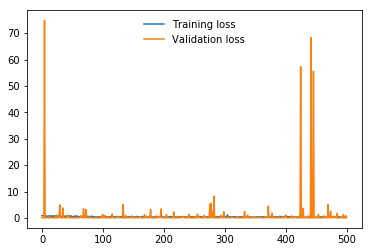

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)

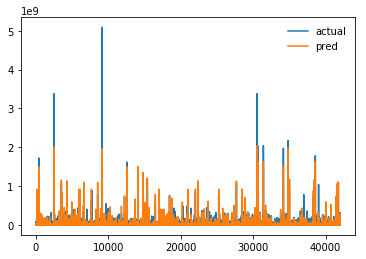

In [34]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [35]:
pred = test_func(model, X_test, y)
pred.shape

[[2.7451330e+07]
 [9.3563970e+06]
 [9.2224389e+09]
 ...
 [7.9536173e+08]
 [9.3563970e+06]
 [1.2684814e+08]]


(10000, 1)

In [36]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,2.745133e+07
1,BTshNOJyKHnT2YIT,9.356397e+06
2,dhdymr0lV8N5kZOT,9.222439e+09
3,VEwyGGMcD56w5BOc,9.356397e+06
4,wmUeMoJZfsqaSX9b,9.356397e+06
5,EtBjGAHmHCe9t7TZ,1.060682e+10
6,hPNH34vmaZtvBtqc,9.356397e+06
7,wXjeI38bYDMJJwZC,1.028892e+08
8,fxZSGX6aPAFKU8W4,1.235054e+10
9,ewr0Fx6ign87OwaV,9.356397e+06


## overfitting

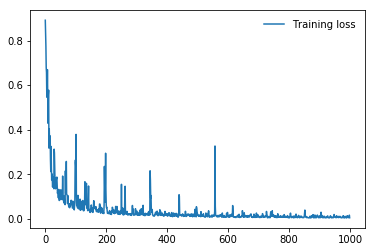

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

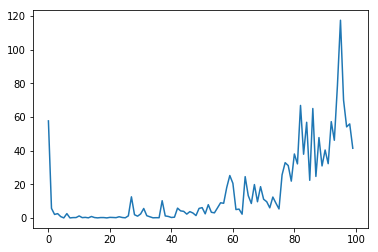

In [19]:
plt.plot(eval_losses, label='Validation loss')


## overfitting2

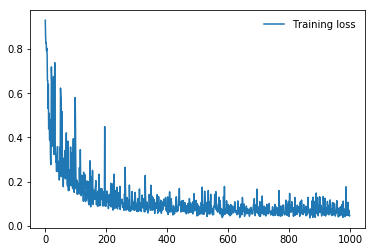

In [18]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)

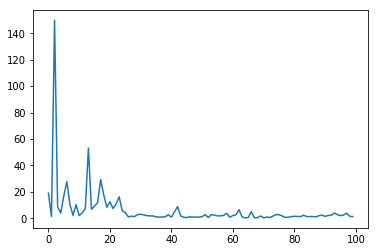

In [19]:
plt.plot(eval_losses, label='Validation loss')


### Submission

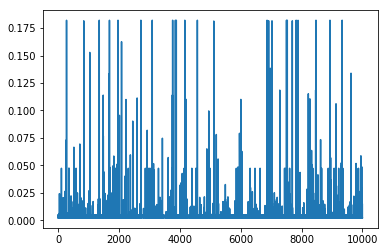

In [26]:
plt.plot(pred, label='pred')


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512